In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import random
import os
import math

#use GPU running
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
#generate mobility data for input with array
data1 = np.load('5min_1node_data.npy')
data100 = np.load('5min_100node_data_id.npy')

print(len(data1))
print(len(data100))
print(data1[0])
print(data100[0])

16800
28000
[5209.9303 9194.304 ]
[   0.     5242.8832 9167.2133]


In [3]:
data1_len = len(data1)
data100_len = len(data100)

x = []
y = []
for i in range(0, data100_len-3000):
  #x.append([data1[j] for j in range(i, i+30)])
  x.append([data100[j] for j in range(i, i+3000, 100)])
  #y.append(data1[i+30])
  y.append(data100[i+3000])
    
print(len(x))
print(len(y))

25000
25000


In [4]:
x = torch.tensor(x, dtype= torch.float32)
y = torch.tensor(y, dtype = torch.float32)
print(x[3])
print(y[3])
print(x.size())
print(y.size())

tensor([[3.0000e+00, 7.8272e+02, 4.9109e+03],
        [3.0000e+00, 7.4838e+02, 4.9402e+03],
        [3.0000e+00, 7.3477e+02, 4.9471e+03],
        [3.0000e+00, 8.0235e+02, 4.9123e+03],
        [3.0000e+00, 7.1102e+02, 4.9539e+03],
        [3.0000e+00, 7.5018e+02, 4.9283e+03],
        [3.0000e+00, 7.9509e+02, 4.9162e+03],
        [3.0000e+00, 7.3823e+02, 4.9431e+03],
        [3.0000e+00, 7.4853e+02, 4.9232e+03],
        [3.0000e+00, 7.3397e+02, 4.9474e+03],
        [3.0000e+00, 7.4841e+02, 4.9378e+03],
        [3.0000e+00, 7.4853e+02, 4.9232e+03],
        [3.0000e+00, 7.3600e+02, 4.8903e+03],
        [3.0000e+00, 7.3397e+02, 4.9474e+03],
        [3.0000e+00, 8.4275e+02, 4.8925e+03],
        [3.0000e+00, 7.6189e+02, 4.9264e+03],
        [3.0000e+00, 7.8253e+02, 4.9090e+03],
        [3.0000e+00, 7.8390e+02, 4.9146e+03],
        [3.0000e+00, 7.3397e+02, 4.9474e+03],
        [3.0000e+00, 7.3397e+02, 4.9474e+03],
        [3.0000e+00, 7.3397e+02, 4.9474e+03],
        [3.0000e+00, 7.3397e+02, 4

In [5]:
#initialization
batch_size = 15
#num_epochs = 10
#input_size = 108
#hidden_size = 216
#layer_num = 3

#input data to dataset
class myselfDataset(Dataset):
  def __init__(self, x, y):
    self.x  = x
    self.y  = y
    self.len = len(x)
  def __getitem__(self,index):
    return self.x[index], self.y[index]
  def __len__(self):
    return self.len

#random distribution with train and test set
def get_dataloader(batch_size):
  dataset = myselfDataset(x,y)
  train_len = int(0.9 * len(dataset))
  length = [train_len, len(dataset)-train_len]
  trainset, validset = random_split(dataset,length)
  #train_x = x[:train_len]
  #train_y = y[:train_len]
  #valid_x = x[train_len:]
  #valid_y = y[train_len:]
  #trainset = myselfDataset(train_x, train_y)
  #validset = myselfDataset(valid_x, valid_y)
  train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
  valid_loader = DataLoader(dataset=validset, batch_size=batch_size, shuffle=True)
  return train_loader, valid_loader

#data_length
length = len(x)
print(length)

dataset = myselfDataset(x,y)
#train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
train_loader, valid_loader = get_dataloader(batch_size)
#print(train_loader)
#print(valid_loader)

25000


In [6]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim.lr_scheduler as lr_scheduler
from torch.autograd import Variable


#intialization
num_epochs = 1500
inputs_size = 30
#hidden_size = 30
outputs_size = 3

#TCN model
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class TCN(nn.Module):
    def __init__(self, c_in, num_channels):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(c_in, num_channels)
        #self.gap = GAP1d()
        self.dropout = nn.Dropout(0.2)
        #self.linear = nn.Linear(layers[-1],c_out)
        #self.init_weights()
        self.decoder = nn.Linear(num_channels[-1], 3)

    #def init_weights(self):
        #self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        return self.decoder(self.dropout(self.tcn(x)[:, :, -1]))
        #x = self.tcn(x)
        #x = self.gap(x)
        #x = self.dropout(x)
        #return self.linear(x)

#param x: size of (Batch, input_channel, seq_len)
#return: size of (Batch, output_channel, seq_len)


#loss and optimizer
tcn = TCN(inputs_size, [30, 30, 30, 30, 30]).to(device)
learning_rate = 0.05
#loss = nn.MSELoss().to(device)
loss = nn.SmoothL1Loss().to(device)
optimizer = optim.Adam(tcn.parameters(), lr=learning_rate)
#optimizer = optim.RMSprop(tcn.parameters(), lr=learning_rate, alpha=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

#training loop
FADarray = []
MADarray = []

for epoch in range(num_epochs):
  MADdist = 0
  for i, (inputs, labels) in enumerate(train_loader):
    #print(inputs.size())
    #print(labels)
    #inputs = inputs.reshape(batch_size, 15, input_dim).to(device)
    #print(inputs.shape)
    optimizer.zero_grad()

    #forward
    y_pred = tcn(inputs.to(device))
    #print(y_pred)
    #y_pred = y_pred.reshape(batch_size, 2)
    #y_pred = [y_pred[:,0,0], y_pred[:,1,0]]
    #y_pred = torch.Tensor(y_pred)
    #y_pred = Variable(y_pred, requires_grad=True)
    #print(y_pred)
    #y_pred = [y_pred[:,0,0], y_pred[:,1,0]]
    l = loss(y_pred.to(device), labels.to(device))
    #print(l)
    
    #backward
    #optimizer.zero_grad()
    l.backward()
    optimizer.step()

    #if (i+1) % 200 == 0:
      #print(f"epoch = {epoch+1}, step = {i+1} , y's prediction = {y_pred[0]}, loss = {l.item():.4f}")
    MADdistx = 0
    for x in range(len(y_pred)):
        y = y_pred[x].cpu().detach().numpy()
        MADa = np.array([y[1], y[2]])
        MADb = np.array([labels[x][1], labels[x][2]])
        MADdistx += np.sqrt(np.sum(np.square(MADa - MADb)))
    MADdist += MADdistx/len(y_pred)
    
    #if (i+1) % 200 == 0:
  #print(f"epoch = {epoch+1}, step = {i+1} , y's prediction = {y_pred[0].tolist()}, loss = {l.item():.4f}")
  #FADdisty = 0
  #for y in range(len(y_pred)):
        #FADa = y_pred[y].cpu().detach().numpy()
        #FADb = np.array(labels[y])
        #FADdisty += np.sqrt(np.sum(np.square(FADa - FADb)))
  #FADdist = FADdisty/len(y_pred)
  MADdist = MADdist/len(train_loader)
  print(f"epoch = {epoch+1}, Mad = {MADdist}") 
  #print(y_pred)
  #FADarray.append(FADdist)
  MADarray.append(MADdist)
  scheduler.step()

epoch = 1, Mad = 2446.758508281708
epoch = 2, Mad = 2298.3945799743656
epoch = 3, Mad = 2379.0999722359816
epoch = 4, Mad = 2328.2088188873686
epoch = 5, Mad = 2383.5631829330837
epoch = 6, Mad = 2371.331212467044
epoch = 7, Mad = 2301.7454815200786
epoch = 8, Mad = 2335.9931402205193
epoch = 9, Mad = 2352.0883049578133
epoch = 10, Mad = 2378.9857990260225
epoch = 11, Mad = 2335.858345812839
epoch = 12, Mad = 2265.8539225056124
epoch = 13, Mad = 2308.4723941098537
epoch = 14, Mad = 2289.3857360805514
epoch = 15, Mad = 2314.0532077719795
epoch = 16, Mad = 2236.452150315013
epoch = 17, Mad = 2262.338721058402
epoch = 18, Mad = 2358.636079444368
epoch = 19, Mad = 2312.162313022019
epoch = 20, Mad = 2318.2052382360457
epoch = 21, Mad = 2342.6386185300203
epoch = 22, Mad = 2235.472807266023
epoch = 23, Mad = 2323.778202264658
epoch = 24, Mad = 2299.8170097252746
epoch = 25, Mad = 2326.3951732198507
epoch = 26, Mad = 2249.107593714523
epoch = 27, Mad = 2299.4080094432893
epoch = 28, Mad = 22

epoch = 221, Mad = 1035.0304855036227
epoch = 222, Mad = 1044.5117862700727
epoch = 223, Mad = 1054.2930606773166
epoch = 224, Mad = 1048.662645679708
epoch = 225, Mad = 1047.8482875995803
epoch = 226, Mad = 1045.172864403713
epoch = 227, Mad = 1046.762380047605
epoch = 228, Mad = 1046.9328877681658
epoch = 229, Mad = 1042.7526131688849
epoch = 230, Mad = 1050.390768163997
epoch = 231, Mad = 1036.9900893010094
epoch = 232, Mad = 1049.5933377645922
epoch = 233, Mad = 1045.411827637649
epoch = 234, Mad = 1050.9927939199204
epoch = 235, Mad = 1044.2717180279835
epoch = 236, Mad = 1045.3653364972529
epoch = 237, Mad = 1044.720534221002
epoch = 238, Mad = 1039.8898478778306
epoch = 239, Mad = 1047.7963013212907
epoch = 240, Mad = 1049.6635700272175
epoch = 241, Mad = 1047.1276051164634
epoch = 242, Mad = 1053.4358172132913
epoch = 243, Mad = 1054.7046648534456
epoch = 244, Mad = 1044.6110208332477
epoch = 245, Mad = 1056.616827786421
epoch = 246, Mad = 1052.3705788968841
epoch = 247, Mad = 

epoch = 439, Mad = 1058.8197782177517
epoch = 440, Mad = 1056.4935195008597
epoch = 441, Mad = 1049.5201092793568
epoch = 442, Mad = 1053.712491036434
epoch = 443, Mad = 1050.007652904404
epoch = 444, Mad = 1048.4964902171873
epoch = 445, Mad = 1059.5094934322992
epoch = 446, Mad = 1035.1205664356016
epoch = 447, Mad = 1048.7361460827096
epoch = 448, Mad = 1053.177848921162
epoch = 449, Mad = 1054.5251799647992
epoch = 450, Mad = 1044.405532461245
epoch = 451, Mad = 1049.7037681495892
epoch = 452, Mad = 1050.4165948366374
epoch = 453, Mad = 1051.312250335926
epoch = 454, Mad = 1051.5911009414663
epoch = 455, Mad = 1056.8386317192708
epoch = 456, Mad = 1051.698401303499
epoch = 457, Mad = 1046.6961899065552
epoch = 458, Mad = 1047.2182721800486
epoch = 459, Mad = 1049.3341153420363
epoch = 460, Mad = 1044.383266995824
epoch = 461, Mad = 1051.6491161402603
epoch = 462, Mad = 1050.658166721607
epoch = 463, Mad = 1041.0976511629315
epoch = 464, Mad = 1056.3051453515538
epoch = 465, Mad = 1

epoch = 657, Mad = 1052.0643422847725
epoch = 658, Mad = 1051.133388129265
epoch = 659, Mad = 1051.0295563767945
epoch = 660, Mad = 1039.4655410053049
epoch = 661, Mad = 1043.8250539861103
epoch = 662, Mad = 1041.9882845941538
epoch = 663, Mad = 1045.6390212460706
epoch = 664, Mad = 1050.1606884000905
epoch = 665, Mad = 1043.1789689345785
epoch = 666, Mad = 1044.1848033216893
epoch = 667, Mad = 1047.9997745474814
epoch = 668, Mad = 1049.7517338049722
epoch = 669, Mad = 1054.2179104763388
epoch = 670, Mad = 1047.116311798114
epoch = 671, Mad = 1055.7175979722663
epoch = 672, Mad = 1046.971866595245
epoch = 673, Mad = 1035.0803134817108
epoch = 674, Mad = 1049.0766196142354
epoch = 675, Mad = 1041.6162449780772
epoch = 676, Mad = 1051.4052543550906
epoch = 677, Mad = 1046.7861639946461
epoch = 678, Mad = 1053.9920904447217
epoch = 679, Mad = 1038.8505925274112
epoch = 680, Mad = 1048.9915250091135
epoch = 681, Mad = 1048.4405787705425
epoch = 682, Mad = 1051.316545811621
epoch = 683, Mad

epoch = 875, Mad = 1035.555942921812
epoch = 876, Mad = 1043.110466535892
epoch = 877, Mad = 1039.7788257937857
epoch = 878, Mad = 1043.6168232707012
epoch = 879, Mad = 1042.764431989914
epoch = 880, Mad = 1045.317573074414
epoch = 881, Mad = 1041.7594320562116
epoch = 882, Mad = 1047.6777463504986
epoch = 883, Mad = 1045.444181842924
epoch = 884, Mad = 1043.4877125606092
epoch = 885, Mad = 1042.330137206713
epoch = 886, Mad = 1043.2083387164546
epoch = 887, Mad = 1049.5089037904534
epoch = 888, Mad = 1042.636506133832
epoch = 889, Mad = 1050.6613985340964
epoch = 890, Mad = 1048.8245017056315
epoch = 891, Mad = 1039.8310543219159
epoch = 892, Mad = 1046.7861717062885
epoch = 893, Mad = 1043.946538029364
epoch = 894, Mad = 1042.2364125801832
epoch = 895, Mad = 1051.7271331106174
epoch = 896, Mad = 1047.1502030914514
epoch = 897, Mad = 1046.0741895406932
epoch = 898, Mad = 1063.5175974645622
epoch = 899, Mad = 1055.1914802711922
epoch = 900, Mad = 1050.3022818595036
epoch = 901, Mad = 1

epoch = 1090, Mad = 1043.7200136116444
epoch = 1091, Mad = 1049.3616641001818
epoch = 1092, Mad = 1046.854521605218
epoch = 1093, Mad = 1048.2253926520027
epoch = 1094, Mad = 1045.2370305355485
epoch = 1095, Mad = 1050.9642975565903
epoch = 1096, Mad = 1053.4495415017236
epoch = 1097, Mad = 1053.625530610051
epoch = 1098, Mad = 1035.8296796000566
epoch = 1099, Mad = 1045.3926942956177
epoch = 1100, Mad = 1042.8360733235459
epoch = 1101, Mad = 1053.9212200115844
epoch = 1102, Mad = 1044.5693166820051
epoch = 1103, Mad = 1048.508185033403
epoch = 1104, Mad = 1049.3103911984585
epoch = 1105, Mad = 1043.537294297645
epoch = 1106, Mad = 1045.8250886784447
epoch = 1107, Mad = 1049.571098380492
epoch = 1108, Mad = 1049.5296571278104
epoch = 1109, Mad = 1047.825762106037
epoch = 1110, Mad = 1042.437292878595
epoch = 1111, Mad = 1049.9966597916496
epoch = 1112, Mad = 1055.8992943382575
epoch = 1113, Mad = 1050.0811220421826
epoch = 1114, Mad = 1045.3879320720475
epoch = 1115, Mad = 1041.5356547

epoch = 1302, Mad = 1046.3856619801834
epoch = 1303, Mad = 1072.079305724631
epoch = 1304, Mad = 1044.2751494165198
epoch = 1305, Mad = 1052.6473281211759
epoch = 1306, Mad = 1045.5719396232198
epoch = 1307, Mad = 1040.2048307774653
epoch = 1308, Mad = 1041.7097733526869
epoch = 1309, Mad = 1048.4418109398325
epoch = 1310, Mad = 1038.7650131069604
epoch = 1311, Mad = 1041.7523245526627
epoch = 1312, Mad = 1051.597617991406
epoch = 1313, Mad = 1052.4614855611158
epoch = 1314, Mad = 1054.0771497106239
epoch = 1315, Mad = 1055.2242191942546
epoch = 1316, Mad = 1049.5326684360923
epoch = 1317, Mad = 1045.5111458371043
epoch = 1318, Mad = 1045.520215216754
epoch = 1319, Mad = 1055.235540972358
epoch = 1320, Mad = 1057.510642617959
epoch = 1321, Mad = 1039.304630417442
epoch = 1322, Mad = 1055.4960739861633
epoch = 1323, Mad = 1057.3518771954737
epoch = 1324, Mad = 1057.8063282153591
epoch = 1325, Mad = 1053.2735729499277
epoch = 1326, Mad = 1047.0556302630548
epoch = 1327, Mad = 1043.825554

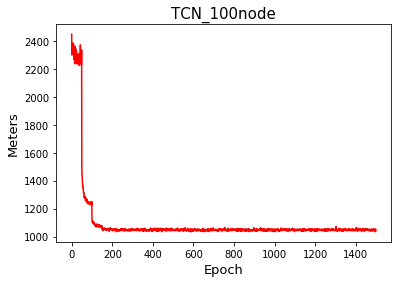

In [9]:
import matplotlib.pyplot as plt 
epocharray = []
epocharray = [i for i in range(num_epochs)]

#plt.plot(epocharray,FADarray, color="blue")
plt.plot(epocharray,MADarray, color="red")
plt.title("TCN_100node",fontsize=15)
plt.xlabel("Epoch",fontsize=13)
plt.ylabel("Meters",fontsize=13)
plt.savefig('TCN_100node.png')
plt.show()

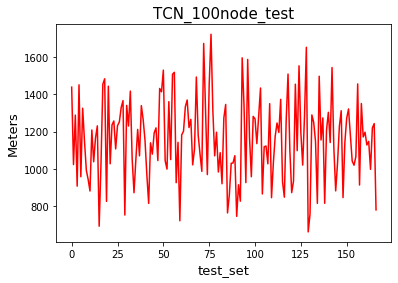

In [10]:
#test set
distarr = []
validarray = []
def validate(valid_loader, model):
  model.eval()
  #avdist = 0
  #test loop
  for i,(inputs, labels) in enumerate(valid_loader):
      #print(inputs)
    #with torch.no_grad():
      #optimizer.zero_grad()
      #inputs = inputs.reshape(batch_size, 1, input_dim).to(device)
      y_pred = model(inputs.to(device))
      #print(y_pred)
      l = loss(y_pred, labels.to(device))
      #l.backward()
      #optimizer.step()
      #if i % batch_size == 0:
      avdist = 0
      for x in range(len(y_pred)):
        a = y_pred[x].cpu().detach().numpy()
        b = np.array(labels[x])
        dist = np.sqrt(np.sum(np.square(a - b)))
        avdist = avdist + dist
      avdist = avdist/len(y_pred)
      distarr.append(avdist)
        #print(f"step = {i}, label's = {labels[0]}, y's prediction = {y_pred[0]}, distance = {dist}")
  #avdist = avdist / len(valid_loader)
  #print(f"average distance = {avdist}"
  
validate(valid_loader, tcn)
validarray = [i for i in range(len(valid_loader))]
plt.plot(validarray,distarr, color="red")
plt.title("TCN_100node_test",fontsize=15)
plt.xlabel("test_set",fontsize=13)
plt.ylabel("Meters",fontsize=13)
plt.savefig('TCN_100node_test.png')
plt.show()